# AI Lab Run Evaluation
Including hiddim, recon and phonepred. 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
from IPython.display import Audio
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.manifold import TSNE   # one type of clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from itertools import combinations
from sklearn.decomposition import PCA
from scipy.linalg import block_diag
import pickle
from scipy import stats
from scipy.interpolate import interp1d
from scipy.stats import sem

In [2]:
from model_padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from misc_my_utils import *
from model_loss import *
from model_model import VQVAEV1 as TheLearner
from model_dataset import TargetDatasetBoundary as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import DS_Tools
from reshandler import DictResHandler
from misc_progress_bar import draw_progress_bar
from test_bnd_detect_tools import *
from misc_tools import PathUtils as PU
from misc_tools import AudioCut, ARPABET
from misc_my_utils import time_to_frame

## Preps

### Dirs

In [3]:
rec_dir = train_cut_phone_

### Constants

In [4]:
EPOCHS = 10
BATCH_SIZE = 1

INPUT_DIM = 64
OUTPUT_DIM = 64

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5
NUM_LAYERS = 2
EMBEDDING_DIM = 128

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16

## Prepare for loading Model

In [5]:
ts = "0301171500"
stop_epoch = "16"
train_name = "C_02"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
assert PU.path_exist(model_save_dir)
print(f"{train_name}-{ts}")

C_02-0301171500


## Load Dataset

In [6]:
TEST = False

In [7]:
mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

unbalanced_guides_path = os.path.join(src_, "phi-unbalanced-guides")
st_valid = pd.read_csv(os.path.join(unbalanced_guides_path, "ST-valid.csv"))

valid_ds = ThisDataset(rec_dir, 
                       st_valid, 
                       transform=mytrans)

# valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

# use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)

In [8]:
valid_num

568

## Model

### Model-related defs

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

# model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
model = TheLearner(enc_size_list=ENC_SIZE_LIST, 
                   dec_size_list=DEC_SIZE_LIST, 
                   embedding_dim=EMBEDDING_DIM, 
                   num_layers=NUM_LAYERS, dropout=DROPOUT)
# model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Load Model

In [10]:
model_name = "{}.pt".format(stop_epoch)
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

VQVAEV1(
  (encoder): VQEncoderV1(
    (lin_1): Linear(in_features=64, out_features=8, bias=True)
    (rnn): LSTM(8, 8, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (lin_2): Linear(in_features=16, out_features=8, bias=True)
    (act): ReLU()
  )
  (decoder): VQDecoderV1(
    (lin_1): Linear(in_features=64, out_features=8, bias=True)
    (rnn): LSTM(8, 8, num_layers=2, batch_first=True, dropout=0.5)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_2): Linear(in_features=8, out_features=64, bias=True)
    (act): ReLU()
  )
  (vq_embedding): Embedding(128, 8)
)

## Inference

In [11]:
def infer(model, valid_loader, model_save_dir, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')): 
    model.eval()
    reshandler = DictResHandler(whole_res_dir=model_save_dir, 
                                 file_prefix="recon-encode-attn")
    all_ze = []
    all_zq = []
    # all_name = []
    all_stop_names = []
    all_sepframes = []
    all_attn = []
    all_recon = []
    all_ori = []
    all_phi_type = []

    for (x, x_lens, pt, sn, sf) in tqdm(valid_loader): 
        # name = name[0]

        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        x_hat, attn_w, (ze, zq) = model(x, x_lens, x_mask)

        ze = ze.cpu().detach().numpy().squeeze()
        zq = zq.cpu().detach().numpy().squeeze()
        attn_w = attn_w.cpu().detach().numpy().squeeze()
        
        recon_x = x_hat.cpu().detach().numpy().squeeze()
        ori_x = x.cpu().detach().numpy().squeeze()

        all_ze += [ze]
        all_zq += [zq]
        all_attn += [attn_w]
        all_recon += [recon_x]
        all_ori += [ori_x]
        # note that this is bit different, not each frame, but each sequence is treated as one data point
        # all_name += [name]
        all_stop_names += sn
        all_sepframes += sf
        all_phi_type += pt
    
    reshandler.res["ze"] = all_ze
    reshandler.res["zq"] = all_zq
    reshandler.res["sn"] = all_stop_names
    reshandler.res["sep-frame"] = all_sepframes
    reshandler.res["attn"] = all_attn
    reshandler.res["recon"] = all_recon
    reshandler.res["ori"] = all_ori
    reshandler.res["phi-type"] = all_phi_type
    reshandler.save()

In [12]:
if __name__ == "__main__": 
    infer()

100%|██████████| 568/568 [00:05<00:00, 111.50it/s]


# Load Res

In [13]:
reshandler = DictResHandler(whole_res_dir=model_save_dir, file_prefix="recon-encode-attn")
reshandler.read()

# Recon

In [14]:
# all
all_recon = reshandler.res["recon"]
all_ori = reshandler.res["ori"]
all_name = reshandler.res["sn"]

In [15]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    # ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

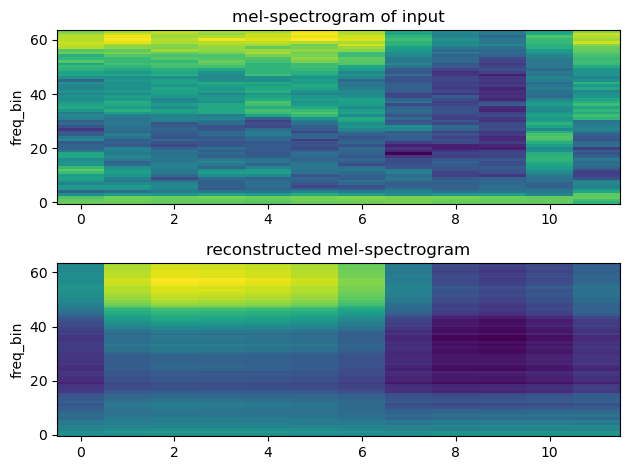

In [18]:
i = random.randint(0, len(all_name))
fig, axs = plt.subplots(2, 1)
plot_spectrogram(all_ori[i].T, title="mel-spectrogram of input", ax=axs[0])
plot_spectrogram(all_recon[i].T, title="reconstructed mel-spectrogram", ax=axs[1])
fig.tight_layout()

## (1) Visualize Attention

In [19]:
# all
all_ze = reshandler.res["ze"]
all_zq = reshandler.res["zq"]
all_sn = reshandler.res["sn"]
all_attn = reshandler.res["attn"]
all_sepframes = reshandler.res["sep-frame"]

In [20]:
def plot_attention(attention_weights, sep_position, stop_name):
    # Ensure attention_weights is a square matrix
    assert attention_weights.shape[0] == attention_weights.shape[1], "Attention weights must be a square matrix."
    
    # Plot the heatmap
    # fig = plt.figure(figsize=(12, 10))
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    ax.xaxis.set_ticks_position('top')  # This moves the ticks and labels to the top
    ax.xaxis.set_label_position('top')  # This moves the axis label to the top
    sns.heatmap(attention_weights, cmap='viridis', cbar=True)
    
    # Draw vertical and horizontal lines for start frames
    plt.axvline(x=sep_position, color='red', linestyle='--', linewidth=0.5)
    plt.axhline(y=sep_position, color='red', linestyle='--', linewidth=0.5)

    plt.title(f'{stop_name}')
    plt.xlabel('Key')
    plt.ylabel('Query')
    plt.xlim(0, attention_weights.shape[1])  # Adjust the x-axis limit
    plt.ylim(attention_weights.shape[0], 0)  # Adjust the y-axis limit (inverted)
    plt.show()

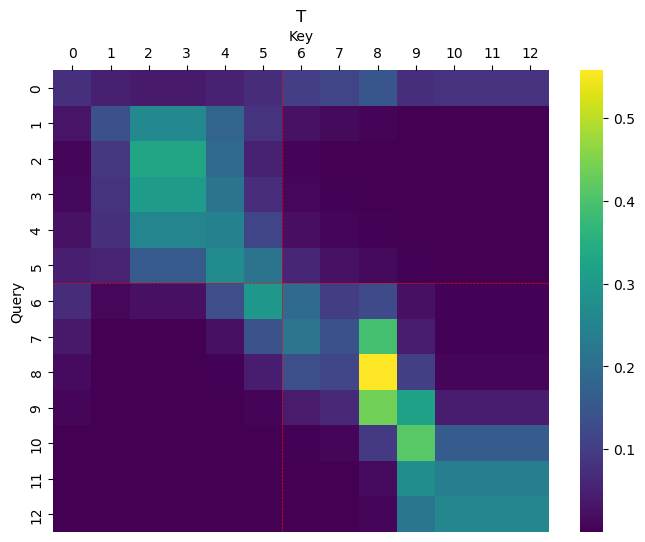

In [21]:
i = torch.randint(0, len(all_attn), size=(1, )).item()

this_attn = all_attn[i]
this_sn = all_sn[i]
this_sepposition = all_sepframes[i]

plot_attention(this_attn, this_sepposition, this_sn)

### Stats

In [22]:
def get_endframes(seppos, attn_size): 
    return [0, seppos], [seppos, attn_size]

In [23]:
def create_phoneme_block_matrix(starts, ends, total):
    # Initialize an empty list to store phoneme block matrices
    phoneme_blocks = []

    # Iterate through the phoneme frames to create each block
    for start_frame, end_frame in list(zip(starts, ends))[:-1]:
        num_frames = end_frame - start_frame
        phoneme_block = np.ones((num_frames, num_frames))
        phoneme_blocks.append(phoneme_block)

    num_frames = total - starts[-1]
    phoneme_block = np.ones((num_frames, num_frames))
    phoneme_blocks.append(phoneme_block)
    block_diag_matrix = block_diag(*phoneme_blocks)

    return block_diag_matrix

In [24]:
def post2pre_filter(start, sep, end): 
    return np.block([[np.zeros((sep-start, end))], [np.ones((end-sep, sep-start)), np.zeros((end-sep, end-sep))]])

In [25]:
def biway_filter(start, sep, end): 
    return np.block([[np.zeros((sep-start, sep-start)), np.ones((sep-start, end-sep))], [np.ones((end-sep, sep-start)), np.zeros((end-sep, end-sep))]])

In [26]:
def get_in_phone_attn(attn, starts, ends, total): 
    block_diag_matrix = create_phoneme_block_matrix(starts, ends, total)
    filtered_attn = block_diag_matrix * attn
    in_phoneme_attn = filtered_attn.sum(-1)
    return in_phoneme_attn

In [27]:
def interpolate_traj(current, n_steps=100): 
    current_steps = np.linspace(0, 1, num=len(current))
    target_steps = np.linspace(0, 1, num=n_steps)
    interp_func = interp1d(current_steps, current, kind='linear')
    return interp_func(target_steps)

In [28]:
# i = torch.randint(0, len(all_attn), size=(1, )).item()
n_steps = 100
first_traj = []
second_traj = []
for i in range(len(all_attn)): 
    this_attn = all_attn[i]
    this_sn = all_sn[i]
    this_sepposition = all_sepframes[i]
    attn_size = this_attn.shape[0]

    # this_attn_filter = post2pre_filter(0, this_sepposition, attn_size)
    this_biway_attn_filter = biway_filter(0, this_sepposition, attn_size)
    # filtered_attn = this_attn_filter * this_attn
    filtered_attn = this_biway_attn_filter * this_attn
    summed_filtered_attn = filtered_attn.sum(-1)

    first_interp = interpolate_traj(summed_filtered_attn[:this_sepposition], n_steps)
    second_interp = interpolate_traj(summed_filtered_attn[this_sepposition:], n_steps)[::-1]
    first_traj.append(first_interp)
    second_traj.append(second_interp)

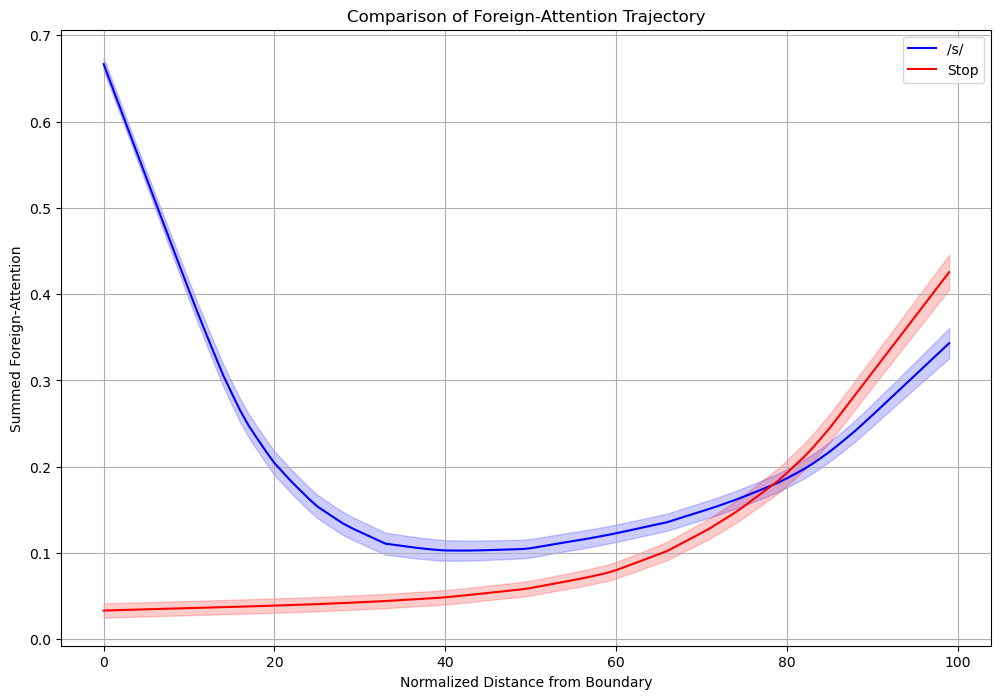

In [29]:
# Convert list of arrays into 2D NumPy arrays for easier manipulation
group1_array = np.array(first_traj)
group2_array = np.array(second_traj)[::-1]

# Calculate the mean trajectory for each group
mean_trajectory_group1 = np.mean(group1_array, axis=0)
mean_trajectory_group2 = np.mean(group2_array, axis=0)

# Calculate the SEM for each step in both groups
sem_group1 = sem(group1_array, axis=0)
sem_group2 = sem(group2_array, axis=0)

# Calculate the 95% CI for both groups
ci_95_group1 = 1.96 * sem_group1
ci_95_group2 = 1.96 * sem_group2

# Upper and lower bounds of the 95% CI for both groups
upper_bound_group1 = mean_trajectory_group1 + ci_95_group1
lower_bound_group1 = mean_trajectory_group1 - ci_95_group1
upper_bound_group2 = mean_trajectory_group2 + ci_95_group2
lower_bound_group2 = mean_trajectory_group2 - ci_95_group2

# Plotting
plt.figure(figsize=(12, 8))

# Mean trajectory for Group 1
plt.plot(mean_trajectory_group1, label='/s/', color='blue')
# 95% CI area for Group 1
plt.fill_between(range(n_steps), lower_bound_group1, upper_bound_group1, color='blue', alpha=0.2)

# Mean trajectory for Group 2
plt.plot(mean_trajectory_group2, label='Stop', color='red')
# 95% CI area for Group 2
plt.fill_between(range(n_steps), lower_bound_group2, upper_bound_group2, color='red', alpha=0.2)

plt.xlabel('Normalized Distance from Boundary')
plt.ylabel('Summed Foreign-Attention')
plt.title('Comparison of Foreign-Attention Trajectory')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
i = torch.randint(0, len(all_attn), size=(1, )).item()
this_attn = all_attn[i]
this_sepposition = all_sepframes[i]
attn_size = this_attn.shape[0]

<Axes: >

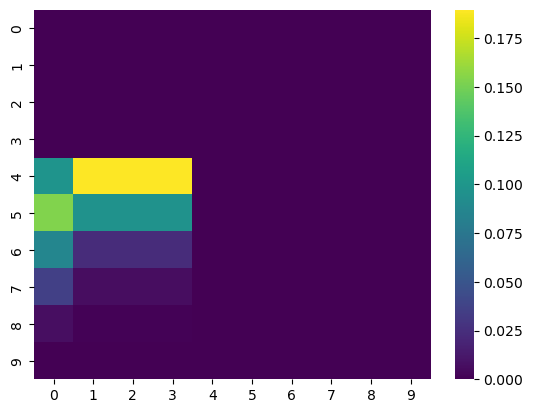

In [31]:
this_attn_filter = post2pre_filter(0, this_sepposition, attn_size)
sns.heatmap(this_attn * this_attn_filter, cmap='viridis', cbar=True)

<Axes: >

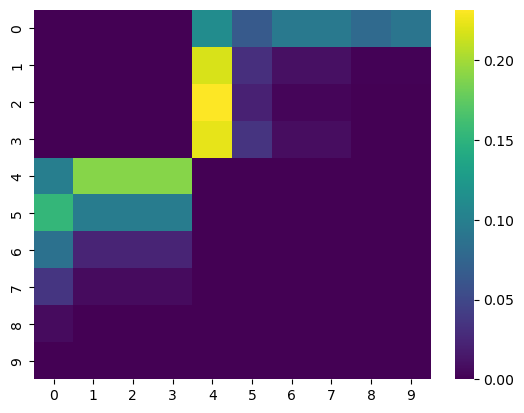

In [32]:
this_biway_filter = biway_filter(0, this_sepposition, attn_size)
sns.heatmap(this_attn * this_biway_filter, cmap='viridis', cbar=True)

### Stats

In [33]:
all_boundary_attn = []
all_middle_attn = []
all_sib_middle_attn = []

for i in tqdm(range(len(all_attn))): 
    this_attn = all_attn[i]
    this_sepposition = all_sepframes[i]
    attn_size = this_attn.shape[0]
    this_startframes, this_endframes = get_endframes(this_sepposition, attn_size)

    boundary_positions = this_endframes[:-1]
    middle_positions = ((np.array(this_startframes) + np.array(this_endframes)) / 2).astype(int).tolist()[:-1]
    sib_middle_positions = ((np.array(this_startframes) + np.array(this_endframes)) / 2).astype(int).tolist()[1:]

    if len(boundary_positions) < 1: 
        continue

    inphone_attn = get_in_phone_attn(this_attn, this_startframes, this_endframes, attn_size)

    for pos in boundary_positions: 
        all_boundary_attn += inphone_attn[boundary_positions].tolist()
    for pos in middle_positions: 
        all_middle_attn += inphone_attn[middle_positions].tolist()
    for pos in sib_middle_positions: 
        all_sib_middle_attn += inphone_attn[sib_middle_positions].tolist()

100%|██████████| 568/568 [00:00<00:00, 23142.79it/s]


In [34]:
stats.ttest_ind(all_boundary_attn, all_middle_attn)

TtestResult(statistic=-27.350529507839305, pvalue=6.665833518545745e-127, df=1134.0)

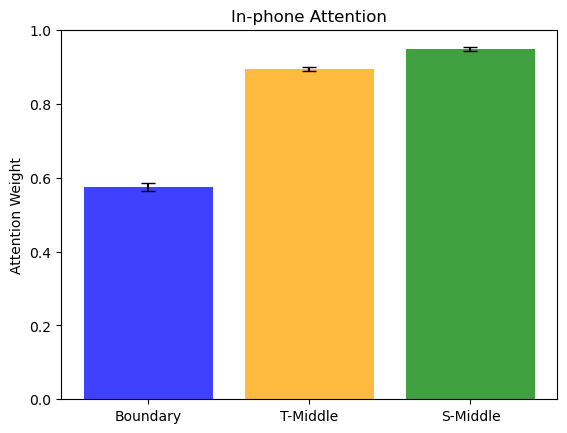

In [35]:
# Sample data for three groups
group1 = all_boundary_attn  # Assuming this is defined elsewhere
group2 = all_middle_attn    # Assuming this is defined elsewhere
group3 = all_sib_middle_attn    # You'll need to define this

# Calculate means for each group
mean1 = np.mean(group1)
mean2 = np.mean(group2)
mean3 = np.mean(group3)  # Mean for the third group

# Calculate standard error of the mean (SEM) for each group
sem1 = np.std(group1, ddof=1) / np.sqrt(len(group1))
sem2 = np.std(group2, ddof=1) / np.sqrt(len(group2))
sem3 = np.std(group3, ddof=1) / np.sqrt(len(group3))  # SEM for the third group

# Prepare plot details
labels = ['Boundary', 'T-Middle', 'S-Middle']  # Include a label for the third group
means = [mean1, mean2, mean3]  # Include mean for the third group
errors = [sem1, sem2, sem3]  # Include SEM for the third group

# Create the bar plot
plt.bar(labels, means, yerr=errors, capsize=5, color=['blue', 'orange', 'green'], alpha=0.75)

# Add title and labels to the plot
plt.title('In-phone Attention')
plt.ylabel('Attention Weight')

# Show the plot
plt.show()


# (2) Hidden Representation Visualization
Note that we also need two plot the singleton stops. So we have to run the model again. 

In [36]:
mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

st_valid = pd.read_csv(os.path.join(src_, "phi-ST-valid.csv"))
t_valid = pd.read_csv(os.path.join(src_, "phi-T-valid.csv"))
t_valid["sibilant_startTime"] = 0
all_valid = pd.concat([t_valid, st_valid], ignore_index=True, sort=False)

valid_ds = ThisDataset(rec_dir, 
                       all_valid, 
                       transform=mytrans)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)

In [38]:
if __name__ == "__main__": 
    infer()

100%|██████████| 1116/1116 [00:05<00:00, 200.78it/s]


In [39]:
reshandler = DictResHandler(whole_res_dir=model_save_dir, file_prefix="hidden")
reshandler.read()

In [40]:
# all
all_ze = reshandler.res["ze"]
all_zq = reshandler.res["zq"]
all_sn = reshandler.res["sn"]
all_sepframes = reshandler.res["sep-frame"]
all_phi_type = reshandler.res["phi-type"]

In [41]:
def cutHid(hid, cutstart, cutend, start_offset=0, end_offset=1): 
    selstart = max(cutstart, int(cutstart + (cutend - cutstart) * start_offset))
    selend = min(cutend, int(cutstart + (cutend - cutstart) * end_offset))
    # hid is (L, H)
    return hid[selstart:selend, :]

In [42]:
# we have very limited data, so we don't need to select, just plot all
def get_toplot(hiddens, sepframes, phi_types, stop_names, offsets=(0, 1)): 
    cutstarts = []
    cutends = []
    for hidden, sepframe, phi_type in zip(hiddens, sepframes, phi_types):
        if phi_type == 'ST':
            cutstarts.append(sepframe)
        else:
            cutstarts.append(0)
        cutends.append(hidden.shape[0])
    
    hid_sel = np.empty((0, 8))
    tag_sel = []
    for (item, start, end, tag) in zip(hiddens, cutstarts, cutends, phi_types): 
        hid = cutHid(item, start, end, offsets[0], offsets[1])
        hidlen = hid.shape[0]
        hid_sel = np.concatenate((hid_sel, hid), axis=0)
        tag_sel += [tag] * hidlen
    return hid_sel, np.array(tag_sel)

In [43]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist = ["BLANK"] + mylist

# Now you can use the loaded object
mymap = TokenMap(mylist)

### T vs ST

(0.0, 0.1)
(0.1, 0.2)
(0.2, 0.30000000000000004)
(0.30000000000000004, 0.4)
(0.4, 0.5)
(0.5, 0.6)
(0.6000000000000001, 0.7000000000000001)
(0.7000000000000001, 0.8)
(0.8, 0.9)
(0.9, 1.0)


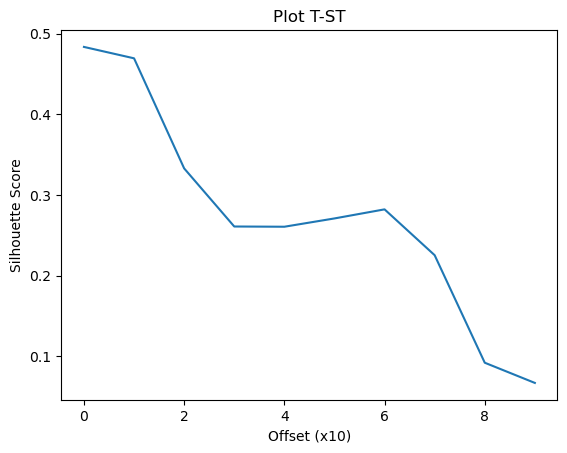

In [44]:
cluster_groups = ["T", "ST"]
sil_list = []
jumper = 0.1
x_range = range(int(1/jumper))

for offset_start_ten in x_range: 
    offsets = (offset_start_ten * jumper, offset_start_ten * jumper + jumper)
    print(offsets)
    # get usable cluster groups
    hidr_cs, tags_cs = get_toplot(hiddens=all_zq, 
                                    sepframes=all_sepframes,
                                    phi_types=all_phi_type,
                                    stop_names=all_sn,
                                    offsets=offsets)
    color_translate = {item: idx for idx, item in enumerate(cluster_groups)}
    # Use Counter to count the occurrences of each item
    item_counts = Counter(tags_cs)
    X, Y = hidr_cs, tags_cs
    silhouette_avg = silhouette_score(X, tags_cs)
    sil_list.append(silhouette_avg)

    # pca = PCA(n_components=2)  # Reduce to 2 dimensions
    # pca_result = pca.fit_transform(X)  # Make sure to convert from PyTorch tensor to NumPy array if necessary
    # plt.figure(figsize=(10, 7))  # Larger figure size for better visibility
    # scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=np.vectorize(mymap.encode)(Y), cmap='viridis', alpha=0.5)
    # plt.colorbar(scatter)
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')
    # plt.title('PCA of Hidden Representations Colored by Ground Truth Labels')
    # plt.show()

plt.plot(x_range, sil_list) # Plot the points
plt.title(f'Plot {"-".join(cluster_groups)}')
plt.xlabel('Offset (x10)')
plt.ylabel('Silhouette Score')
plt.show()


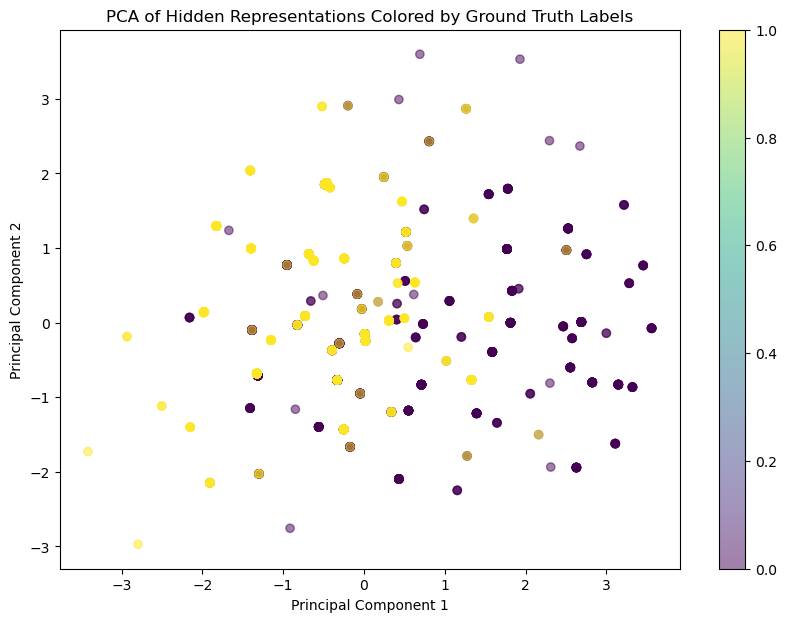

In [45]:
hidr_cs, tags_cs = get_toplot(hiddens=all_zq, 
                                sepframes=all_sepframes,
                                phi_types=all_phi_type,
                                stop_names=all_sn,
                                offsets=(0.4, 0.6))
color_translate = {item: idx for idx, item in enumerate(cluster_groups)}
# Use Counter to count the occurrences of each item
# item_counts = Counter(tags_cs)
X, Y = hidr_cs, tags_cs

pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_result = pca.fit_transform(X)  # Make sure to convert from PyTorch tensor to NumPy array if necessary

# Create a scatter plot colored by the ground truth labels
plt.figure(figsize=(10, 7))  # Larger figure size for better visibility
# mymap.encode
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=np.vectorize(lambda x: color_translate[x])(Y), cmap='viridis', alpha=0.5)

# Add a color bar to show the correspondence between color and class
plt.colorbar(scatter)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Hidden Representations Colored by Ground Truth Labels')
plt.show()

In [46]:
# Number of clusters
n_clusters = len(cluster_groups)

# Running KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(X)


In [47]:
silhouette_avg = silhouette_score(X, tags_cs)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.24573627794249378


In [48]:
adjusted_rand_score(tags_cs, cluster_labels)

0.17538390169792656

In [49]:
v_measure_score(tags_cs, cluster_labels)

0.22455627693144573

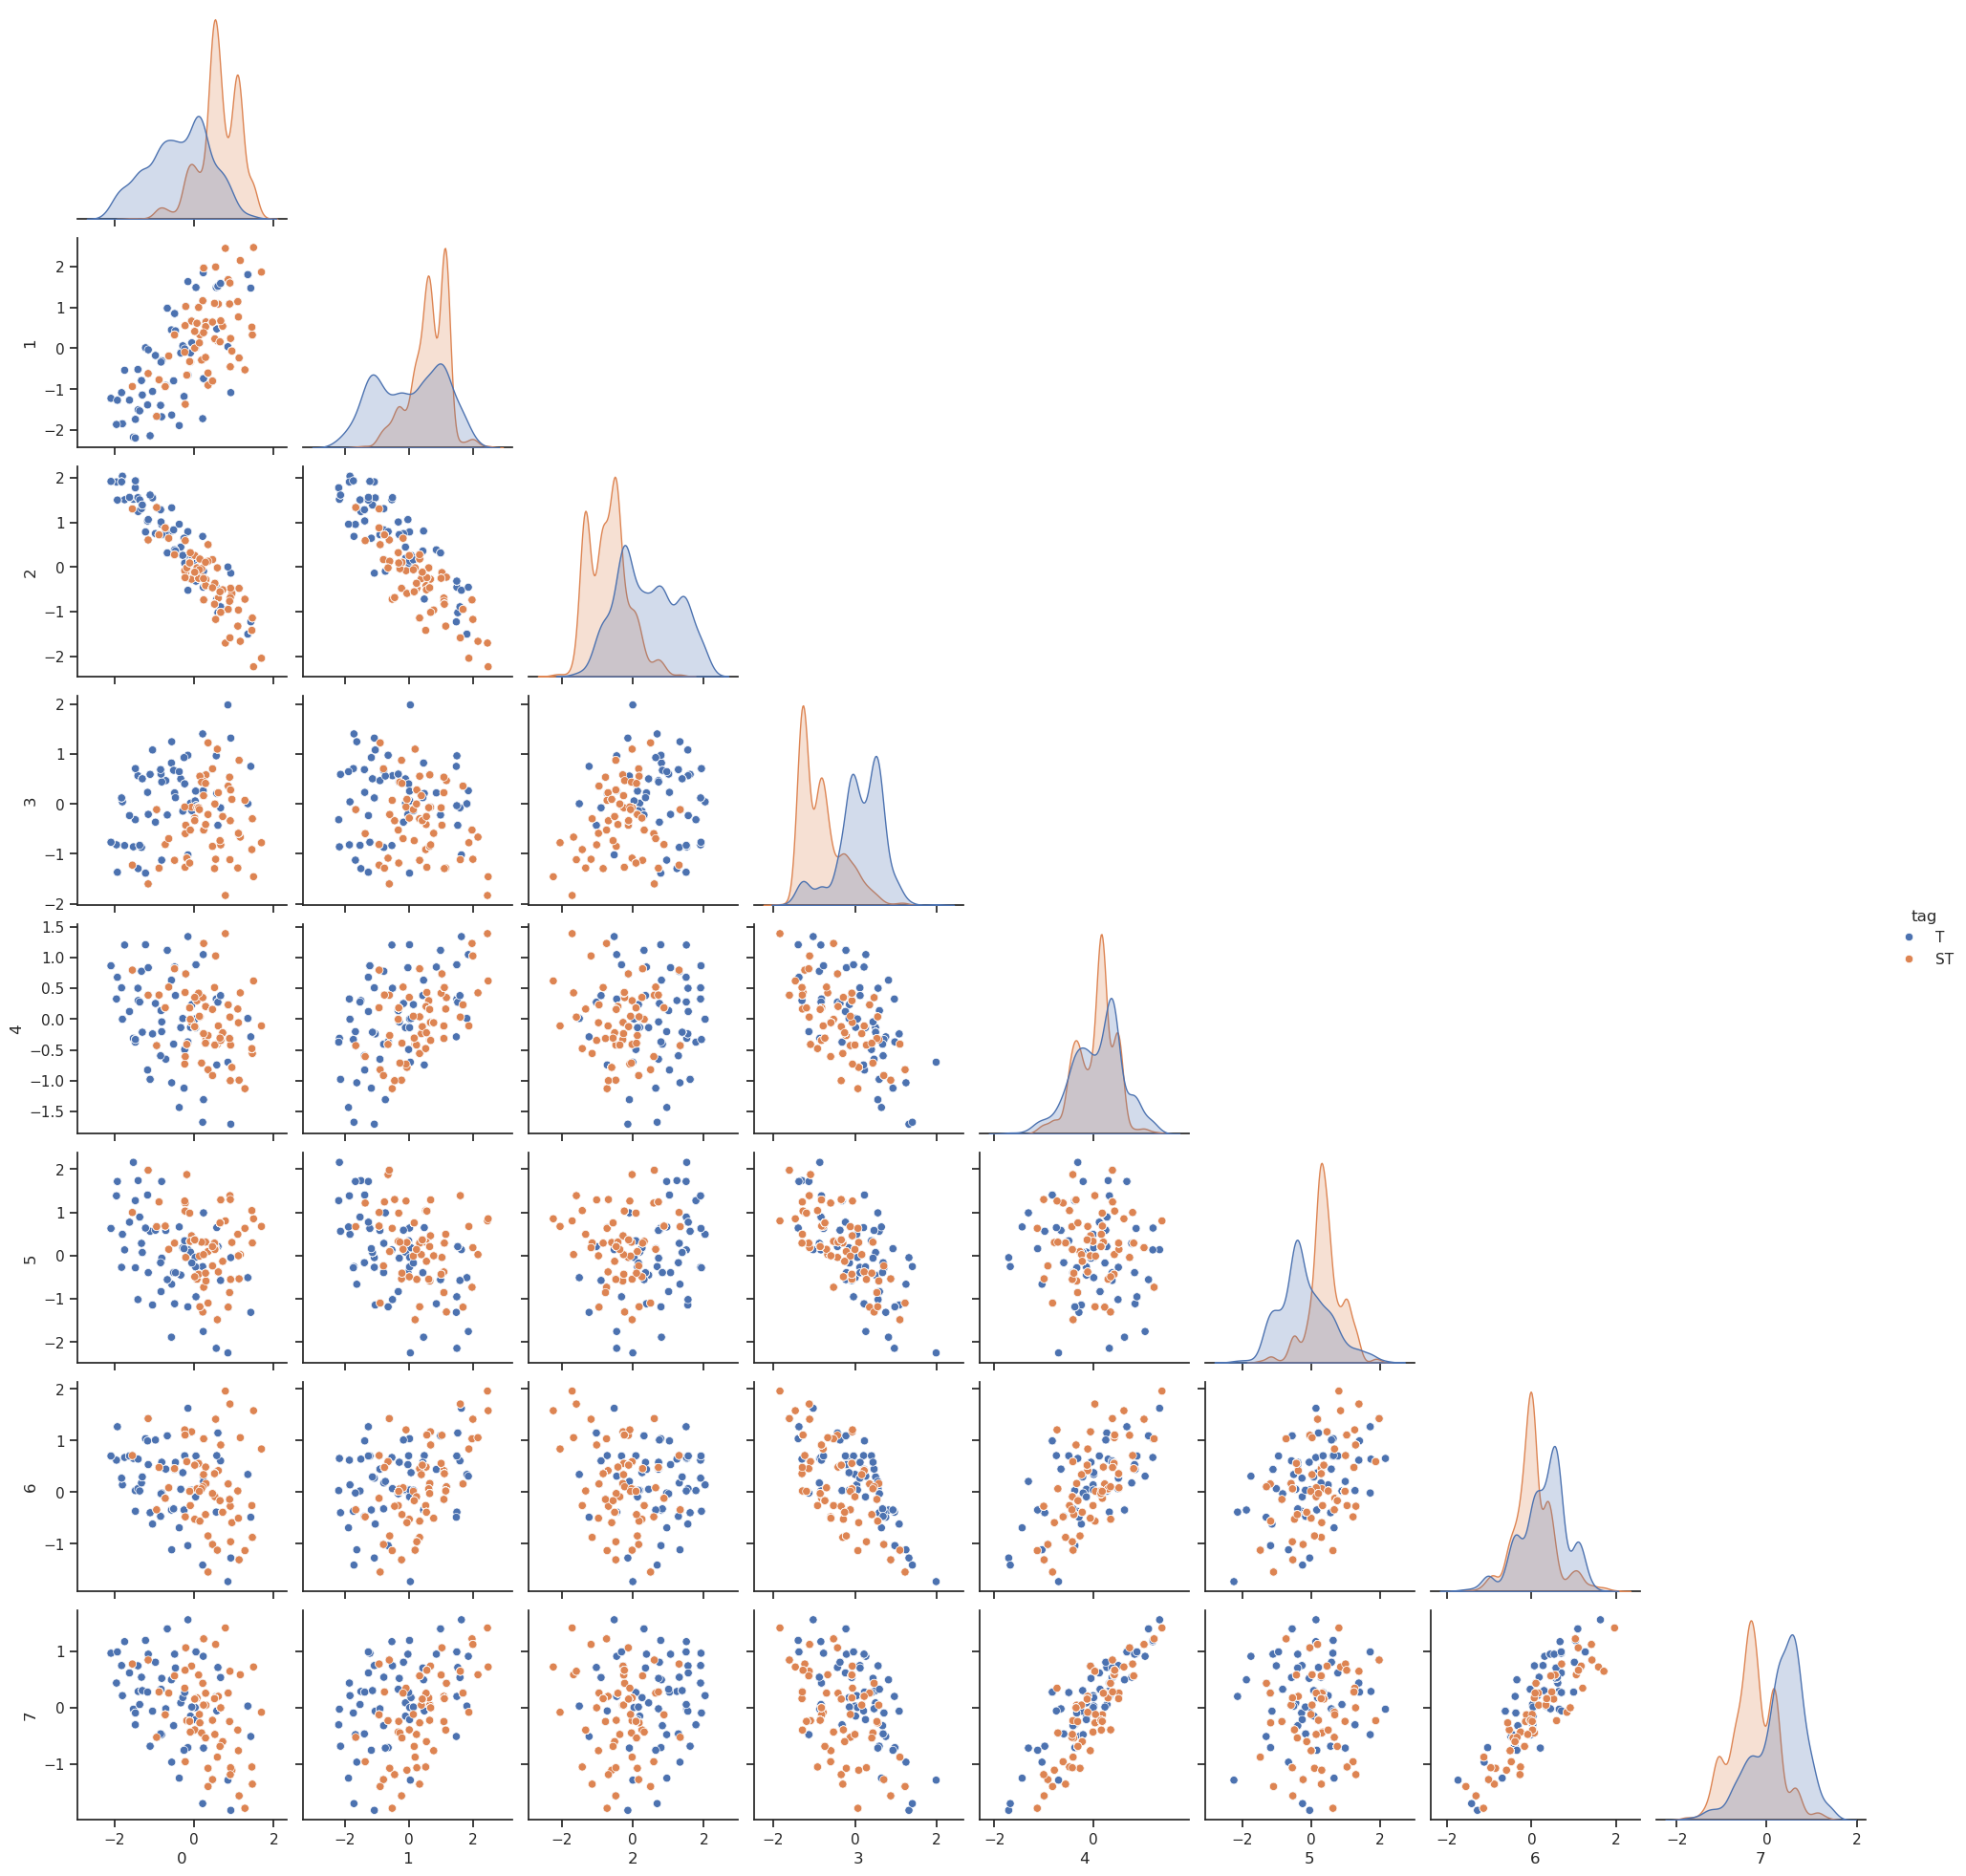

In [50]:
X = hidr_cs
y = tags_cs

colors = [color_translate[item] for item in y]
df = pd.DataFrame(X)
df["tag"] = y

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df,hue='tag', corner=True, diag_kind="kde")
# g.map_lower(sns.kdeplot, levels=4, color=".2")

# Plan for next step: it seems that there are plenty of variability in "boundary attention". In order to see whether there are rather stable performance in this, we are going to test the epochs and their relation to the different performances. 

### Six-Group Test

In [56]:
# we have very limited data, so we don't need to select, just plot all
def get_toplot(hiddens, sepframes, phi_types, stop_names, offsets=(0, 1)): 
    cutstarts = []
    cutends = []
    for hidden, sepframe, phi_type in zip(hiddens, sepframes, phi_types):
        if phi_type == 'ST':
            cutstarts.append(sepframe)
        else:
            cutstarts.append(0)
        cutends.append(hidden.shape[0])
    
    hid_sel = np.empty((0, 8))
    tag_sel = []
    for (item, start, end, phi, stop_name) in zip(hiddens, cutstarts, cutends, phi_types, stop_names): 
        tag = ("S" if phi == "ST" else "") + stop_name
        hid = cutHid(item, start, end, offsets[0], offsets[1])
        hidlen = hid.shape[0]
        hid_sel = np.concatenate((hid_sel, hid), axis=0)
        tag_sel += [tag] * hidlen
    return hid_sel, np.array(tag_sel)

In [57]:
hids = all_zq
# hids = all_ze

(0.0, 0.1)
(0.1, 0.2)
(0.2, 0.30000000000000004)
(0.30000000000000004, 0.4)
(0.4, 0.5)
(0.5, 0.6)
(0.6000000000000001, 0.7000000000000001)
(0.7000000000000001, 0.8)
(0.8, 0.9)
(0.9, 1.0)


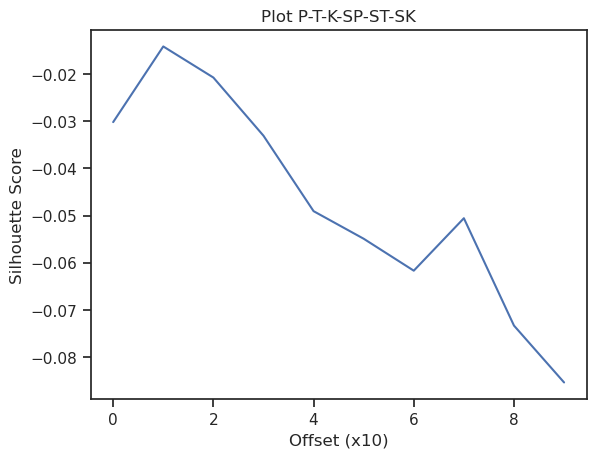

In [58]:
cluster_groups = ["P", "T", "K", "SP", "ST", "SK"]
sil_list = []
jumper = 0.1
x_range = range(int(1/jumper))

for offset_start_ten in x_range: 
    offsets = (offset_start_ten * jumper, offset_start_ten * jumper + jumper)
    print(offsets)
    # get usable cluster groups
    hidr_cs, tags_cs = get_toplot(hiddens=hids, 
                                    sepframes=all_sepframes,
                                    phi_types=all_phi_type,
                                    stop_names=all_sn,
                                    offsets=offsets)
    color_translate = {item: idx for idx, item in enumerate(cluster_groups)}
    # Use Counter to count the occurrences of each item
    item_counts = Counter(tags_cs)
    X, Y = hidr_cs, tags_cs
    silhouette_avg = silhouette_score(X, tags_cs)
    sil_list.append(silhouette_avg)

    # pca = PCA(n_components=2)  # Reduce to 2 dimensions
    # pca_result = pca.fit_transform(X)  # Make sure to convert from PyTorch tensor to NumPy array if necessary
    # plt.figure(figsize=(10, 7))  # Larger figure size for better visibility
    # scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=np.vectorize(mymap.encode)(Y), cmap='viridis', alpha=0.5)
    # plt.colorbar(scatter)
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')
    # plt.title('PCA of Hidden Representations Colored by Ground Truth Labels')
    # plt.show()

plt.plot(x_range, sil_list) # Plot the points
plt.title(f'Plot {"-".join(cluster_groups)}')
plt.xlabel('Offset (x10)')
plt.ylabel('Silhouette Score')
plt.show()


In [55]:
# import matplotlib.pyplot as plt

# # Define the data points and their corresponding classes
# x = [1, 2, 3, 4, 5, 6]
# y = [2, 4, 6, 8, 10, 12]
# classes = [0, 1, 2, 3, 4, 5]
# class_names = ['Class A', 'Class B', 'Class C', 'Class D', 'Class E', 'Class F']

# # Define the colors for each class
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

# # Plot the scatter plot
# scatter = plt.scatter(x, y, c=classes, cmap='viridis', alpha=0.5)

# # Add a color bar to show the correspondence between color and class
# plt.colorbar(scatter)

# # Add labels and title
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Scatter Plot with 6 Classes')

# # Create a legend with class names
# legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=class_names[i], markerfacecolor=colors[i]) for i in range(len(class_names))]
# plt.legend(handles=legend_elements)

# # Show the plot
# plt.show()


ValueError: 'c' argument has 1182 elements, which is inconsistent with 'x' and 'y' with size 1633.

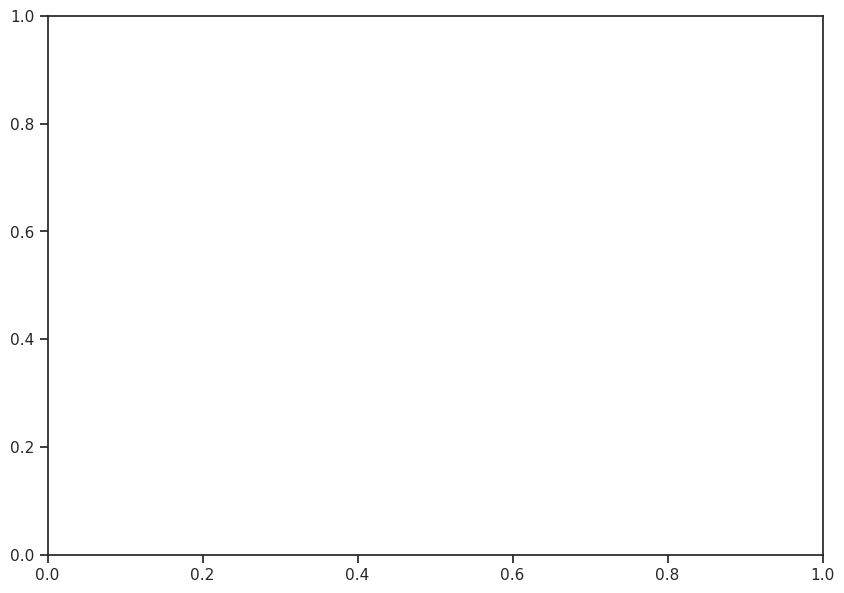

In [59]:
hidr_cs, tags_cs = get_toplot(hiddens=all_zq, 
                                sepframes=all_sepframes,
                                phi_types=all_phi_type,
                                stop_names=all_sn,
                                offsets=(0.4, 0.6))
color_translate = {item: idx for idx, item in enumerate(cluster_groups)}
colors_used = np.vectorize(lambda x: color_translate[x])(Y)
# Use Counter to count the occurrences of each item
# item_counts = Counter(tags_cs)
X, Y = hidr_cs, tags_cs

pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_result = pca.fit_transform(X)  # Make sure to convert from PyTorch tensor to NumPy array if necessary

# Create a scatter plot colored by the ground truth labels
plt.figure(figsize=(10, 7))  # Larger figure size for better visibility
# mymap.encode
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors_used, alpha=1)

# Add a color bar to show the correspondence between color and class
# plt.colorbar(scatter)
# legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=Y[i], markerfacecolor=colors_used[i]) for i in range(len(Y))]
# plt.legend(handles=legend_elements)
plt.legend()

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Hidden Representations Colored by Ground Truth Labels')
plt.show()

In [60]:
# Number of clusters
n_clusters = len(cluster_groups)

# Running KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(X)


In [61]:
silhouette_avg = silhouette_score(X, tags_cs)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: -0.0612518433647612


In [62]:
adjusted_rand_score(tags_cs, cluster_labels)

0.16551353079086656

In [63]:
v_measure_score(tags_cs, cluster_labels)

0.2589705630521289

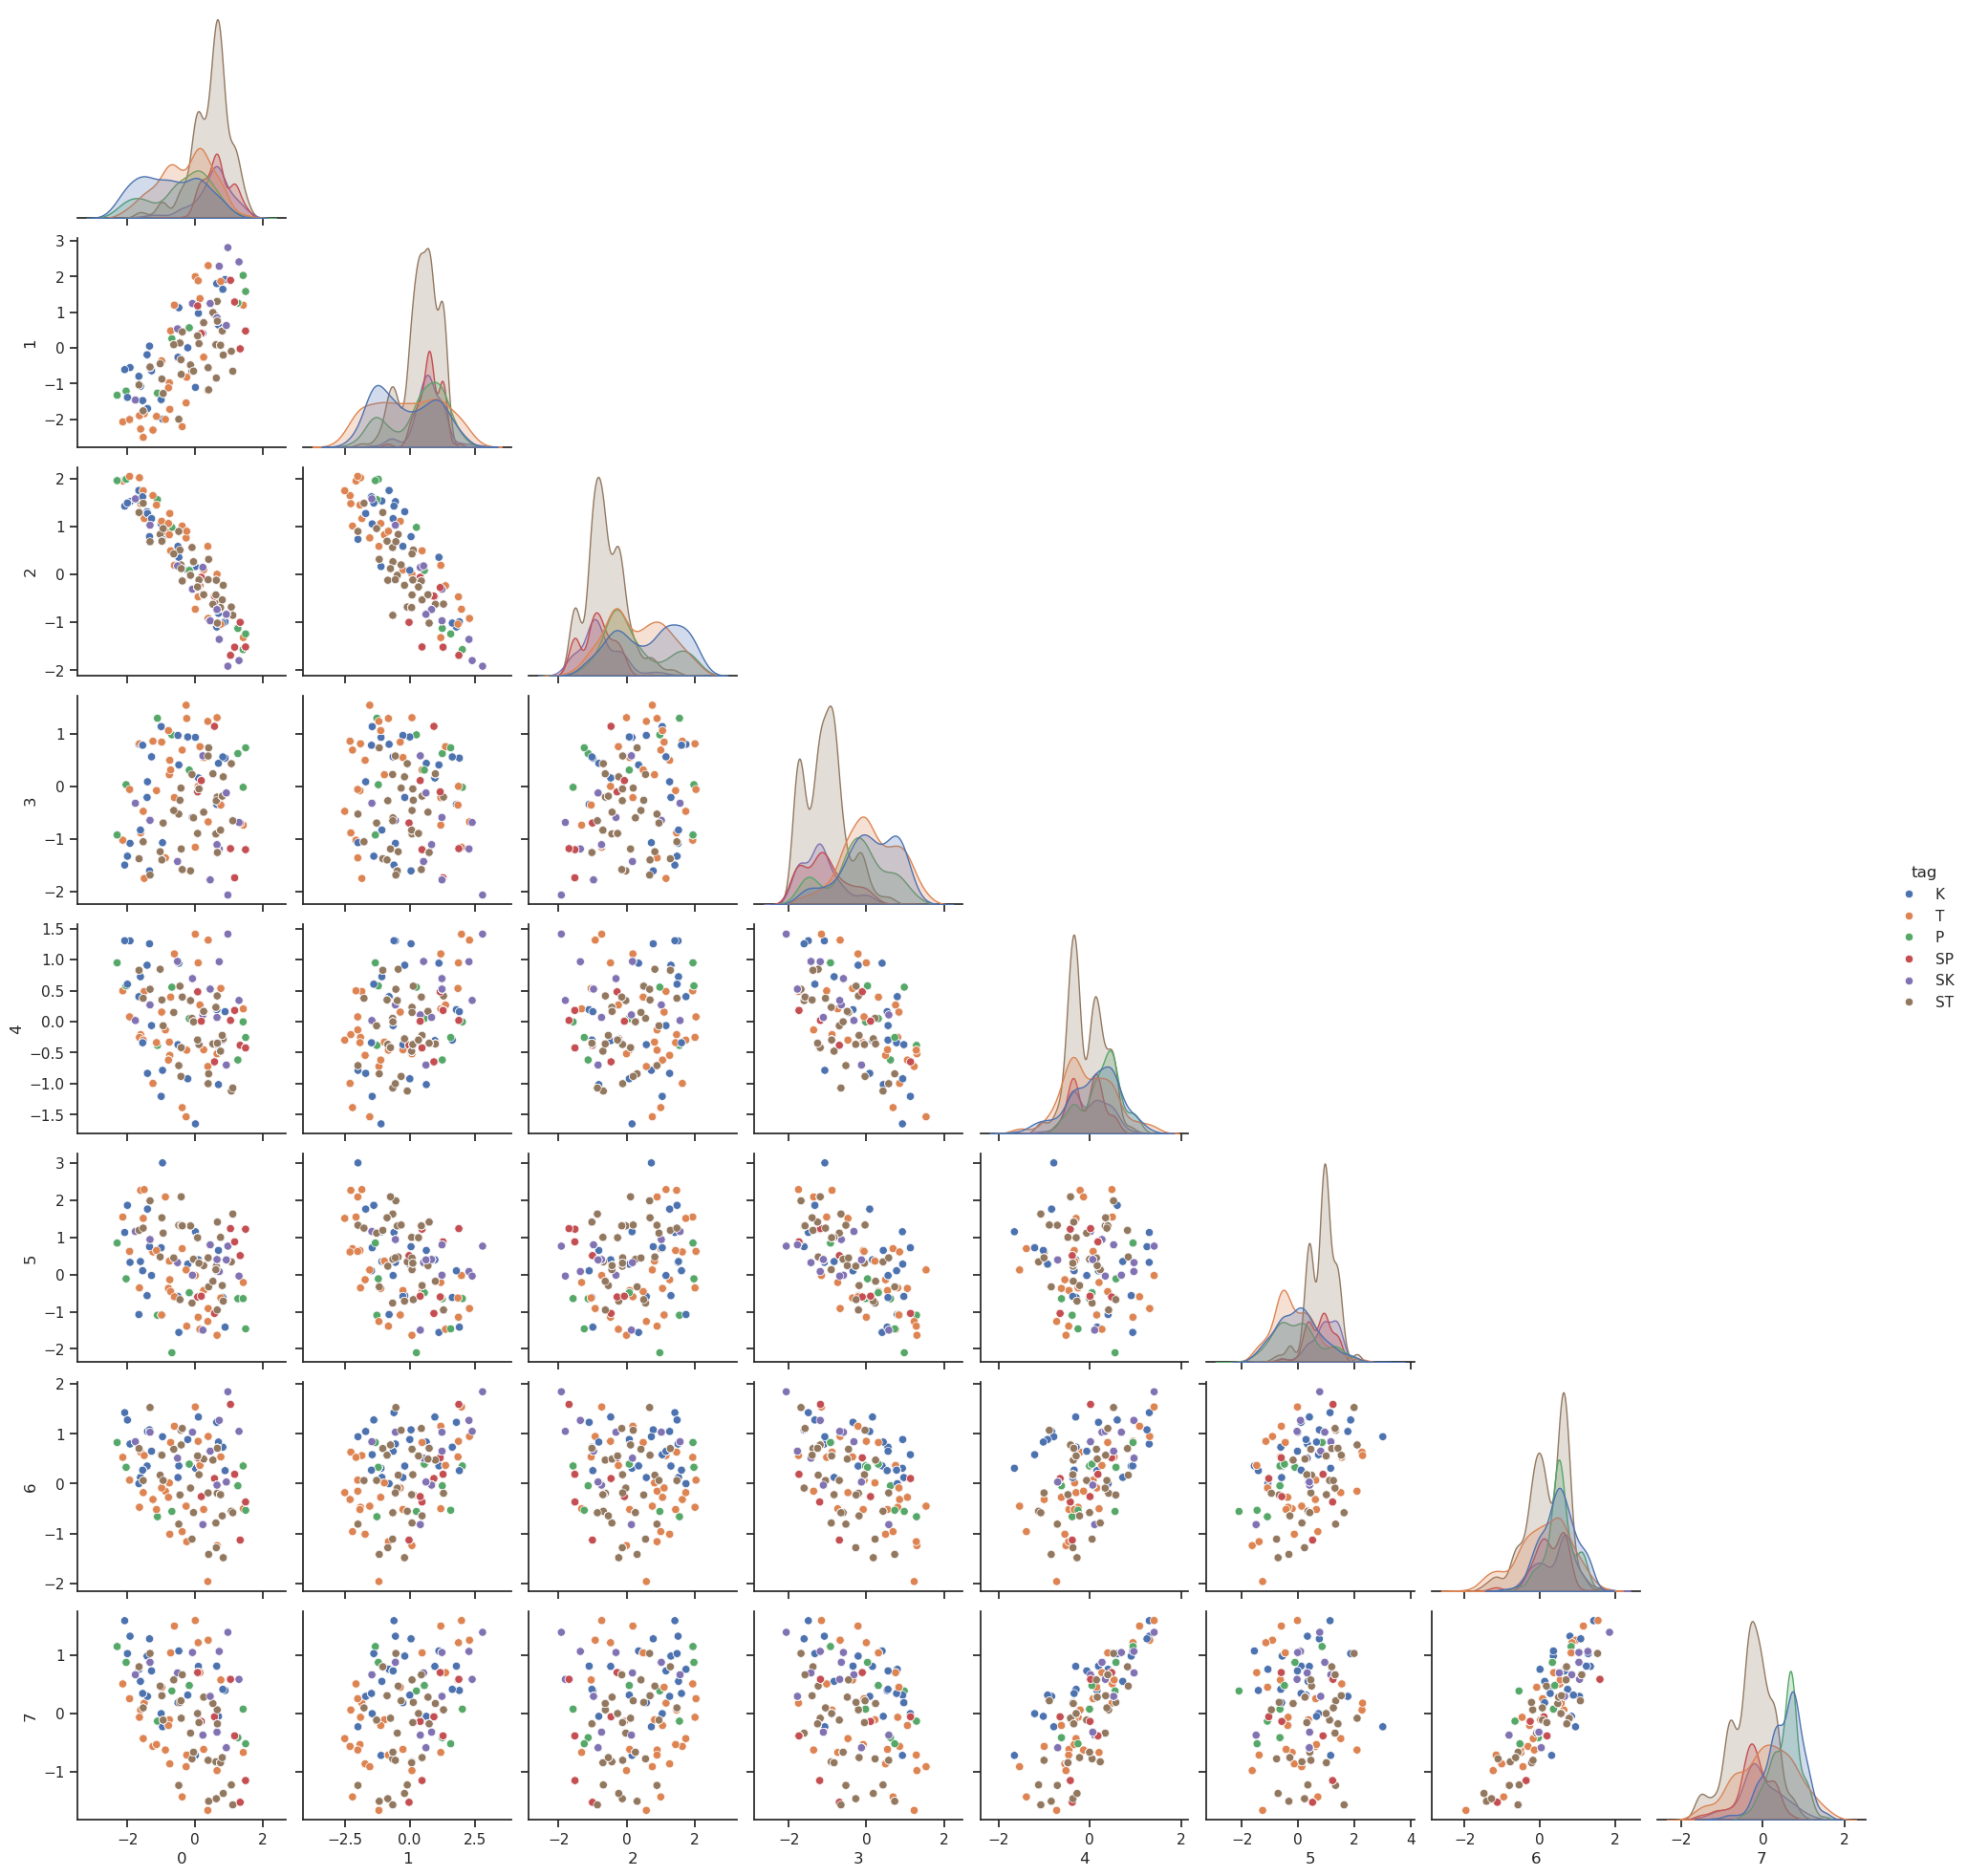

In [64]:
X = hidr_cs
y = tags_cs

colors = [color_translate[item] for item in y]
df = pd.DataFrame(X)
df["tag"] = y

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df,hue='tag', corner=True, diag_kind="kde")
# g.map_lower(sns.kdeplot, levels=4, color=".2")